#### Initializaiton and useful function

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Set a random seed for reproducibility
np.random.seed(228) 

In [3]:
def generate_data(num_samples=100, input_range=(-1, 1), noise_level=0.1, distribution='uniform'):
    """
    Generate synthetic data for training and testing the neural network.
    
    Parameters:
    - num_samples: Number of data points to generate
    - input_range: Min and max values for input features
    - noise_level: Amount of random noise to add to output
    - distribution: 'uniform' or 'normal' for different data distributions
    
    Returns:
    - X: Input features with shape (num_samples, 2)
    - y: Target values with shape (num_samples, 1)
    """
    # Generate input values (X) based on specified distribution
    if distribution == 'uniform':
        X = np.random.uniform(input_range[0], input_range[1], (num_samples, 2))
    elif distribution == 'normal':
        # Center the normal distribution at 0 with scale to mostly stay within input_range
        scale = (input_range[1] - input_range[0]) / 6  # ~99.7% of values within range
        X = np.random.normal(0, scale, (num_samples, 2))
        # Clip values to ensure they stay within input_range
        X = np.clip(X, input_range[0], input_range[1])
    else:
        raise ValueError("Distribution must be 'uniform' or 'normal'")
    
    # Generate output values based on the formula y = x1² + x2 + 1
    # This is the formula mentioned in the materials X file
    y = X[:, 0]**2 + X[:, 1] + 1
    
    # Add random noise to output
    if noise_level > 0:
        y += np.random.normal(0, noise_level, num_samples)
    
    # Reshape y to be a column vector
    y = y.reshape(-1, 1)
    
    return X, y

In [4]:
def visualize_data(X, y):
    """
    Create 2D plots to visualize the generated data and underlying function.
    """
    # Create a figure with subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Scatter plot of X1 vs Y with color representing X2
    scatter = axs[0].scatter(X[:, 0], y, c=X[:, 1], cmap='viridis', alpha=0.8)
    axs[0].set_xlabel('X1')
    axs[0].set_ylabel('Y')
    axs[0].set_title('Data: X1 vs Y (color = X2)')
    fig.colorbar(scatter, ax=axs[0], label='X2 Value')
    
    # Plot 2: Scatter plot of X2 vs Y with color representing X1
    scatter = axs[1].scatter(X[:, 1], y, c=X[:, 0], cmap='plasma', alpha=0.8)
    axs[1].set_xlabel('X2')
    axs[1].set_ylabel('Y')
    axs[1].set_title('Data: X2 vs Y (color = X1)')
    fig.colorbar(scatter, ax=axs[1], label='X1 Value')
    
    # Add 2D visualization of the true function at fixed X2 values
    x1_range = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    
    # Plot for a few fixed X2 values
    x2_values = [min(X[:, 1]), np.mean(X[:, 1]), max(X[:, 1])]
    for x2 in x2_values:
        y_true = x1_range**2 + x2 + 1
        axs[0].plot(x1_range, y_true, '--', alpha=0.5, 
                   label=f'True function at X2={x2:.2f}')
    
    axs[0].legend()
    plt.tight_layout()
    plt.show()
    
    # Create contour plot to visualize the function in 2D
    plt.figure(figsize=(8, 6))
    
    # Create a mesh for the underlying function
    x_range = np.linspace(min(X[:, 0]), max(X[:, 0]), 50)
    y_range = np.linspace(min(X[:, 1]), max(X[:, 1]), 50)
    X_mesh, Y_mesh = np.meshgrid(x_range, y_range)
    Z_mesh = X_mesh**2 + Y_mesh + 1  # The true function without noise
    
    # Create a contour plot
    contour = plt.contourf(X_mesh, Y_mesh, Z_mesh, 50, cmap='viridis', alpha=0.7)
    plt.colorbar(contour, label='Z Value (Y)')
    
    # Overlay the actual data points
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap='plasma', 
               edgecolors='k', s=50, alpha=0.8)
    
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Contour Plot of True Function with Data Points')
    plt.show()

#### Neural Network Implementation

In [5]:
class NeuralNetwork:
    def __init__(self, weights=None, biases=None, learning_rate=0.01):
        """
        Initialize a neural network with 2 input nodes, 2 hidden nodes, and 1 output node.
        
        Parameters:
        - weights: List of 6 weight values. If None, weights will be set to predefined values.
        - biases: List of 3 bias values. If None, biases will be set to predefined values.
        - learning_rate: Learning rate for gradient descent.
        """
        # Default weights and biases as specified in the lecture example
        if weights is None:
            self.w1 = 1.0    # Connection from input x1 to hidden node 1
            self.w2 = 0.5    # Connection from input x1 to hidden node 2
            self.w3 = 1.0    # Connection from input x2 to hidden node 1
            self.w4 = -0.5   # Connection from input x2 to hidden node 2
            self.w5 = 1.0    # Connection from hidden node 1 to output
            self.w6 = 1.0    # Connection from hidden node 2 to output
        else:
            if len(weights) != 6:
                raise ValueError("weights must be a list of 6 values")
            self.w1, self.w2, self.w3, self.w4, self.w5, self.w6 = weights
            
        if biases is None:
            self.b1 = 0.5    # Bias for hidden node 1
            self.b2 = 0.0    # Bias for hidden node 2
            self.b3 = 0.5    # Bias for output node
        else:
            if len(biases) != 3:
                raise ValueError("biases must be a list of 3 values")
            self.b1, self.b2, self.b3 = biases
        
        self.learning_rate = learning_rate
        self.loss_history = []
        
    def relu(self, x):
        """ReLU activation function: return x if x > 0, else return 0"""
        return max(0, x)
    
    def relu_derivative(self, x):
        """Derivative of ReLU function: return 1 if x > 0, else return 0"""
        return 1 if x > 0 else 0
    
    def forward_pass(self, x1, x2):
        """
        Perform a forward pass through the network given inputs x1 and x2.
        
        Returns the output and all intermediate values needed for backpropagation.
        """
        # Calculate inputs to hidden nodes
        h1_input = x1 * self.w1 + x2 * self.w3 + self.b1
        h2_input = x1 * self.w2 + x2 * self.w4 + self.b2
        
        # Apply activation function to get hidden node outputs
        h1_output = self.relu(h1_input)
        h2_output = self.relu(h2_input)
        
        # Calculate input to output node
        y_input = h1_output * self.w5 + h2_output * self.w6 + self.b3
        
        # Apply activation function to get final output
        # Using ReLU for the output as well
        y_output = self.relu(y_input)
        
        # Return all values needed for backpropagation
        return y_output, y_input, h1_output, h2_output, h1_input, h2_input
    
    def calculate_loss(self, y_pred, y_true):
        """Calculate mean squared error loss: (y_pred - y_true)²"""
        return (y_pred - y_true) ** 2
    
    def backpropagation(self, x1, x2, y_true, y_pred, y_input, h1_output, h2_output, h1_input, h2_input):
        """
        Perform backpropagation to update weights and biases.
        
        Parameters:
        - x1, x2: Input values
        - y_true: Target output value
        - y_pred: Predicted output value
        - y_input: Input to output node (before activation)
        - h1_output, h2_output: Outputs from hidden nodes
        - h1_input, h2_input: Inputs to hidden nodes (before activation)
        """
        # Calculate partial derivative of loss with respect to predicted output
        dL_dy_pred = 2 * (y_pred - y_true)
        
        # Calculate derivative of output activation
        dy_pred_dy_input = self.relu_derivative(y_input)
        
        # Calculate partial derivatives for output layer
        dL_dw5 = dL_dy_pred * dy_pred_dy_input * h1_output
        dL_dw6 = dL_dy_pred * dy_pred_dy_input * h2_output
        dL_db3 = dL_dy_pred * dy_pred_dy_input
        
        # Calculate partial derivatives for hidden layer
        dL_dh1 = dL_dy_pred * dy_pred_dy_input * self.w5
        dL_dh2 = dL_dy_pred * dy_pred_dy_input * self.w6
        
        dh1_dh1_input = self.relu_derivative(h1_input)
        dh2_dh2_input = self.relu_derivative(h2_input)
        
        dL_dw1 = dL_dh1 * dh1_dh1_input * x1
        dL_dw3 = dL_dh1 * dh1_dh1_input * x2
        dL_db1 = dL_dh1 * dh1_dh1_input
        
        dL_dw2 = dL_dh2 * dh2_dh2_input * x1
        dL_dw4 = dL_dh2 * dh2_dh2_input * x2
        dL_db2 = dL_dh2 * dh2_dh2_input
        
        # Update weights and biases using gradient descent
        self.w1 -= self.learning_rate * dL_dw1
        self.w2 -= self.learning_rate * dL_dw2
        self.w3 -= self.learning_rate * dL_dw3
        self.w4 -= self.learning_rate * dL_dw4
        self.w5 -= self.learning_rate * dL_dw5
        self.w6 -= self.learning_rate * dL_dw6
        
        self.b1 -= self.learning_rate * dL_db1
        self.b2 -= self.learning_rate * dL_db2
        self.b3 -= self.learning_rate * dL_db3
    
    def train(self, X, y, epochs=100):
        """
        Train the neural network on the given dataset.
        
        Parameters:
        - X: Input features with shape (num_samples, 2)
        - y: Target values with shape (num_samples, 1)
        - epochs: Number of training iterations
        
        Returns:
        - loss_history: List of average loss values for each epoch
        """
        self.loss_history = []
        
        for epoch in range(epochs):
            epoch_loss = 0
            
            for i in range(len(X)):
                x1, x2 = X[i]
                y_true = y[i][0]
                
                # Forward pass
                y_pred, y_input, h1_output, h2_output, h1_input, h2_input = self.forward_pass(x1, x2)
                
                # Calculate loss
                loss = self.calculate_loss(y_pred, y_true)
                epoch_loss += loss
                
                # Backpropagation
                self.backpropagation(x1, x2, y_true, y_pred, y_input, h1_output, h2_output, h1_input, h2_input)
            
            # Calculate average loss for this epoch
            avg_loss = epoch_loss / len(X)
            self.loss_history.append(avg_loss)
            
            # Print progress every 100 epochs
            if (epoch + 1) % 100 == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
        
        return self.loss_history
    
    def predict(self, X):
        """
        Make predictions for a batch of inputs.
        
        Parameters:
        - X: Input features with shape (num_samples, 2)
        
        Returns:
        - predictions: Predicted values with shape (num_samples, 1)
        """
        predictions = []
        
        for i in range(len(X)):
            x1, x2 = X[i]
            y_pred, _, _, _, _, _ = self.forward_pass(x1, x2)
            predictions.append(y_pred)
        
        return np.array(predictions).reshape(-1, 1)
    
    def get_weights_and_biases(self):
        """Return current weights and biases as lists for easy access."""
        weights = [self.w1, self.w2, self.w3, self.w4, self.w5, self.w6]
        biases = [self.b1, self.b2, self.b3]
        return weights, biases

#### Experimentation Functions

In [6]:
def plot_loss_history(loss_history):
    """Plot the loss history during training."""
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.title('Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    plt.show()

def visualize_predictions(model, X, y):
    """
    Create 2D plots to visualize the predictions versus actual data.
    """
    # Get predictions
    predictions = model.predict(X)
    
    # Create figure with subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Predicted vs Actual for X1
    axs[0].scatter(X[:, 0], y, c='b', marker='o', alpha=0.5, label='Actual Data')
    axs[0].scatter(X[:, 0], predictions, c='r', marker='x', alpha=0.5, label='Predictions')
    axs[0].set_xlabel('X1')
    axs[0].set_ylabel('Y')
    axs[0].set_title('Predictions vs Actual (X1 vs Y)')
    axs[0].legend()
    
    # Plot 2: Predicted vs Actual for X2
    axs[1].scatter(X[:, 1], y, c='b', marker='o', alpha=0.5, label='Actual Data')
    axs[1].scatter(X[:, 1], predictions, c='r', marker='x', alpha=0.5, label='Predictions')
    axs[1].set_xlabel('X2')
    axs[1].set_ylabel('Y')
    axs[1].set_title('Predictions vs Actual (X2 vs Y)')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create contour plots to visualize the predicted function vs true function
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # Create a mesh grid for visualization
    x_range = np.linspace(min(X[:, 0]), max(X[:, 0]), 50)
    y_range = np.linspace(min(X[:, 1]), max(X[:, 1]), 50)
    X_mesh, Y_mesh = np.meshgrid(x_range, y_range)
    
    # True function for comparison
    Z_true = X_mesh**2 + Y_mesh + 1
    
    # Predicted function
    mesh_points = np.column_stack((X_mesh.flatten(), Y_mesh.flatten()))
    Z_pred = model.predict(mesh_points).reshape(X_mesh.shape)
    
    # Plot true function contour
    contour1 = axs[0].contourf(X_mesh, Y_mesh, Z_true, 50, cmap='viridis')
    fig.colorbar(contour1, ax=axs[0], label='Y Value')
    axs[0].set_xlabel('X1')
    axs[0].set_ylabel('X2')
    axs[0].set_title('True Function')
    
    # Plot predicted function contour
    contour2 = axs[1].contourf(X_mesh, Y_mesh, Z_pred, 50, cmap='viridis')
    fig.colorbar(contour2, ax=axs[1], label='Y Value')
    axs[1].set_xlabel('X1')
    axs[1].set_ylabel('X2')
    axs[1].set_title('Predicted Function')
    
    plt.tight_layout()
    plt.show()
    
    # Plot prediction error
    plt.figure(figsize=(8, 6))
    error = np.abs(predictions - y)
    plt.scatter(X[:, 0], X[:, 1], c=error.flatten(), cmap='coolwarm', s=50, alpha=0.8)
    plt.colorbar(label='Absolute Error')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Prediction Error Distribution')
    plt.show()

def create_random_weights_biases():
    """Generate random starting weights and biases."""
    weights = np.random.uniform(-1, 1, 6)
    biases = np.random.uniform(-1, 1, 3)
    return weights, biases

#### Experimentation Examples

In [7]:
# Example 1: Training with default parameters
def experiment_default():
    print("EXPERIMENT: Default Parameters")
    print("-" * 50)
    
    # Generate data
    X, y = generate_data(num_samples=100)
    
    # Visualize the data
    visualize_data(X, y)
    
    # Create and train neural network
    nn = NeuralNetwork()
    loss_history = nn.train(X, y, epochs=1000)
    
    # Plot loss history
    plot_loss_history(loss_history)
    
    # Visualize predictions
    visualize_predictions(nn, X, y)
    
    # Print final weights and biases
    weights, biases = nn.get_weights_and_biases()
    print("\nFinal weights:", weights)
    print("Final biases:", biases)
    print("Final loss:", loss_history[-1])
    
    return nn

In [8]:
# Example 2: Effect of learning rate
def experiment_learning_rate(rates=[0.005, 0.01, 0.05, 0.1, 0.25]):
    print("EXPERIMENT: Different Learning Rates")
    print("-" * 50)
    
    # Generate data
    X, y = generate_data(num_samples=100)
    
    plt.figure(figsize=(12, 8))
    
    for lr in rates:
        print(f"Training with learning rate: {lr}")
        nn = NeuralNetwork(learning_rate=lr)
        loss_history = nn.train(X, y, epochs=1000)
        
        plt.plot(loss_history, label=f'LR = {lr}')
        print(f"Final loss: {loss_history[-1]:.4f}")
    
    plt.title('Loss During Training for Different Learning Rates')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
# Example 3: Effect of data distribution
def experiment_data_distribution():
    print("EXPERIMENT: Different Data Distributions")
    print("-" * 50)
    
    # Generate data with different distributions
    X_uniform, y_uniform = generate_data(num_samples=100, distribution='uniform')
    X_normal, y_normal = generate_data(num_samples=100, distribution='normal')
    
    # Visualize the data
    print("Uniform Distribution:")
    visualize_data(X_uniform, y_uniform)
    
    print("Normal Distribution:")
    visualize_data(X_normal, y_normal)
    
    # Create and train networks
    nn_uniform = NeuralNetwork()
    nn_normal = NeuralNetwork()
    
    print("Training on uniform data:")
    loss_uniform = nn_uniform.train(X_uniform, y_uniform, epochs=1000)
    
    print("\nTraining on normal data:")
    loss_normal = nn_normal.train(X_normal, y_normal, epochs=1000)
    
    # Plot loss history
    plt.figure(figsize=(12, 8))
    plt.plot(loss_uniform, label='Uniform Distribution')
    plt.plot(loss_normal, label='Normal Distribution')
    plt.title('Loss During Training for Different Data Distributions')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Visualize predictions
    print("Predictions for uniform data:")
    visualize_predictions(nn_uniform, X_uniform, y_uniform)
    
    print("Predictions for normal data:")
    visualize_predictions(nn_normal, X_normal, y_normal)

In [10]:
# Example 4: Effect of dataset size
def experiment_dataset_size(sizes=[30, 100, 300, 500]):
    print("EXPERIMENT: Different Dataset Sizes")
    print("-" * 50)
    
    plt.figure(figsize=(12, 8))
    
    for size in sizes:
        print(f"Training with dataset size: {size}")
        X, y = generate_data(num_samples=size)
        nn = NeuralNetwork()
        loss_history = nn.train(X, y, epochs=1000)
        
        plt.plot(loss_history, label=f'Size = {size}')
        print(f"Final loss: {loss_history[-1]:.4f}")
    
    plt.title('Loss During Training for Different Dataset Sizes')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
# Example 5: Effect of initial weights and biases
def experiment_random_initialization(num_trials=5):
    print("EXPERIMENT: Random Weight and Bias Initialization")
    print("-" * 50)
    
    # Generate data
    X, y = generate_data(num_samples=100)
    
    plt.figure(figsize=(12, 8))
    
    for i in range(num_trials):
        weights, biases = create_random_weights_biases()
        print(f"Trial {i+1}")
        print(f"Initial weights: {weights}")
        print(f"Initial biases: {biases}")
        
        nn = NeuralNetwork(weights=weights, biases=biases)
        loss_history = nn.train(X, y, epochs=1000)
        
        plt.plot(loss_history, label=f'Trial {i+1}')
        print(f"Final loss: {loss_history[-1]:.4f}\n")
    
    plt.title('Loss During Training for Different Initial Weights and Biases')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Running experiments

EXPERIMENT: Default Parameters
--------------------------------------------------


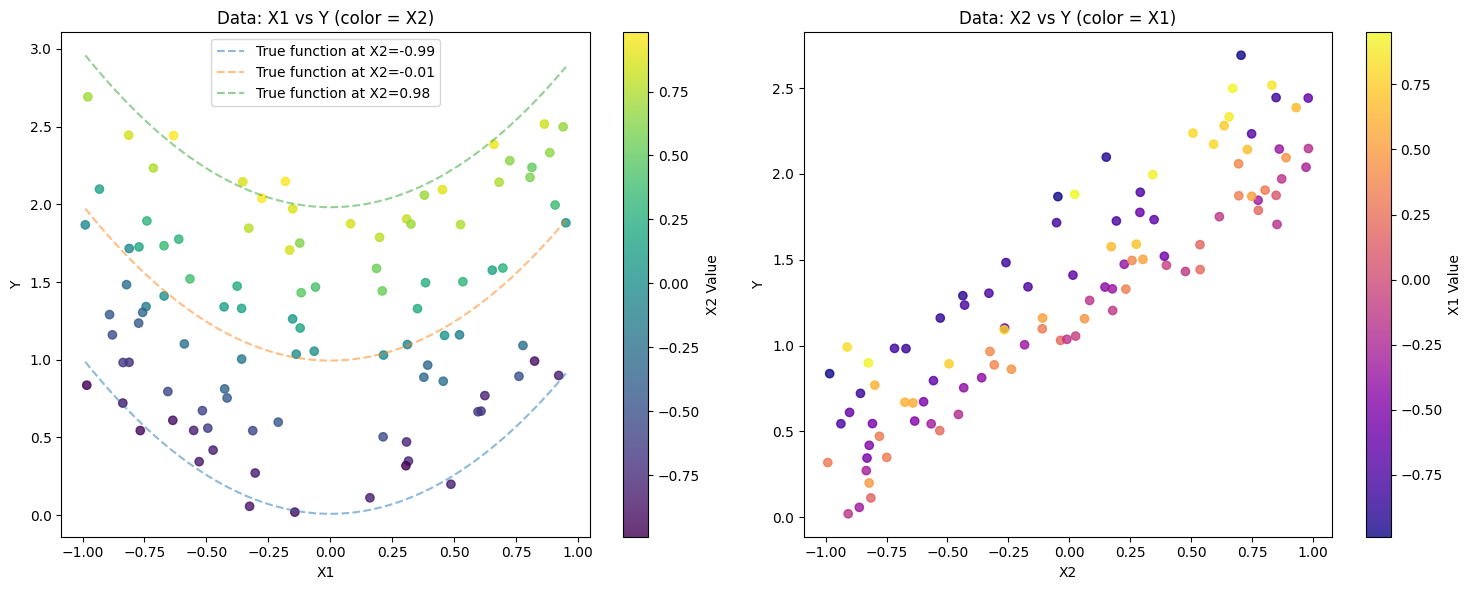

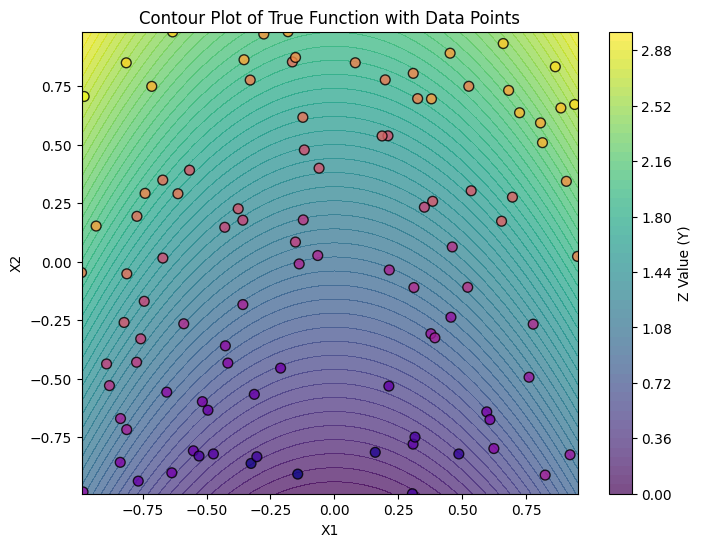

Epoch 1/1000, Loss: 0.3004
Epoch 100/1000, Loss: 0.0142
Epoch 200/1000, Loss: 0.0126
Epoch 300/1000, Loss: 0.0126
Epoch 400/1000, Loss: 0.0126
Epoch 500/1000, Loss: 0.0126
Epoch 600/1000, Loss: 0.0126
Epoch 700/1000, Loss: 0.0126
Epoch 800/1000, Loss: 0.0126
Epoch 900/1000, Loss: 0.0126
Epoch 1000/1000, Loss: 0.0126


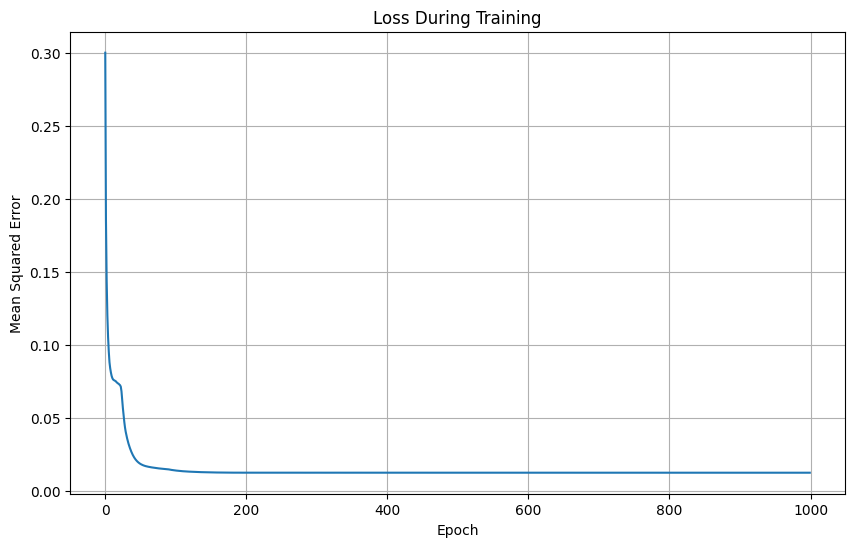

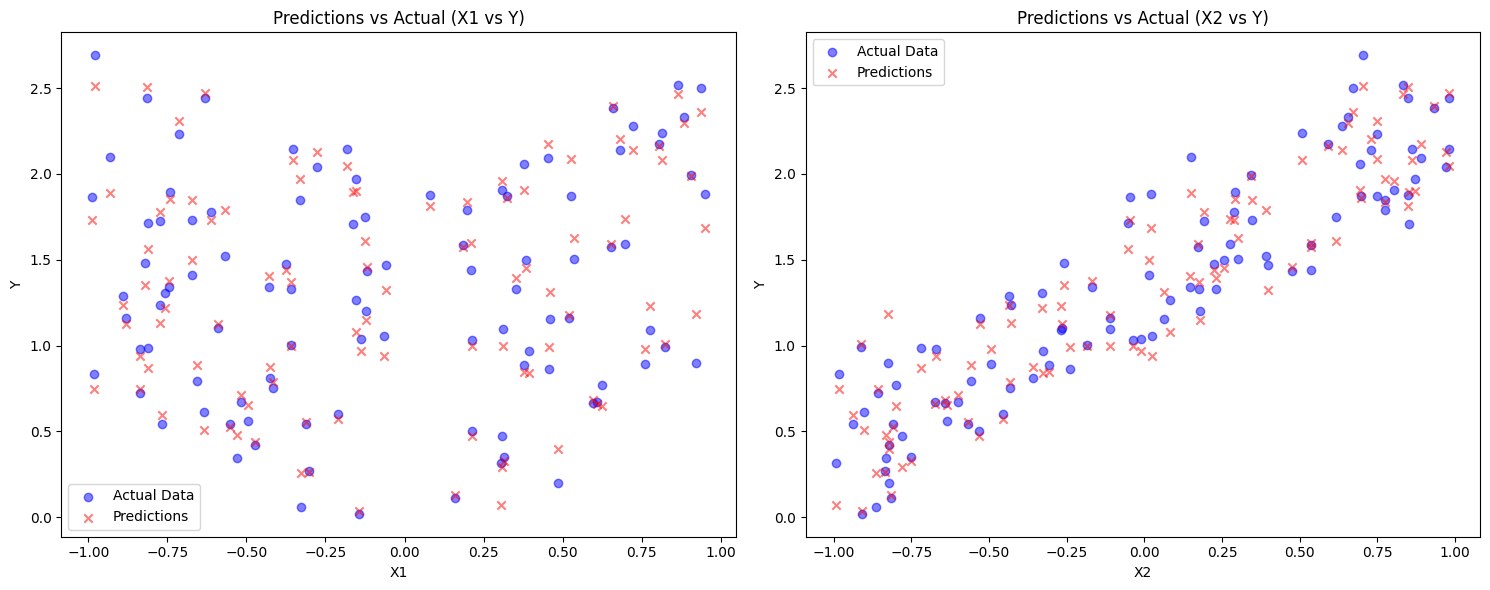

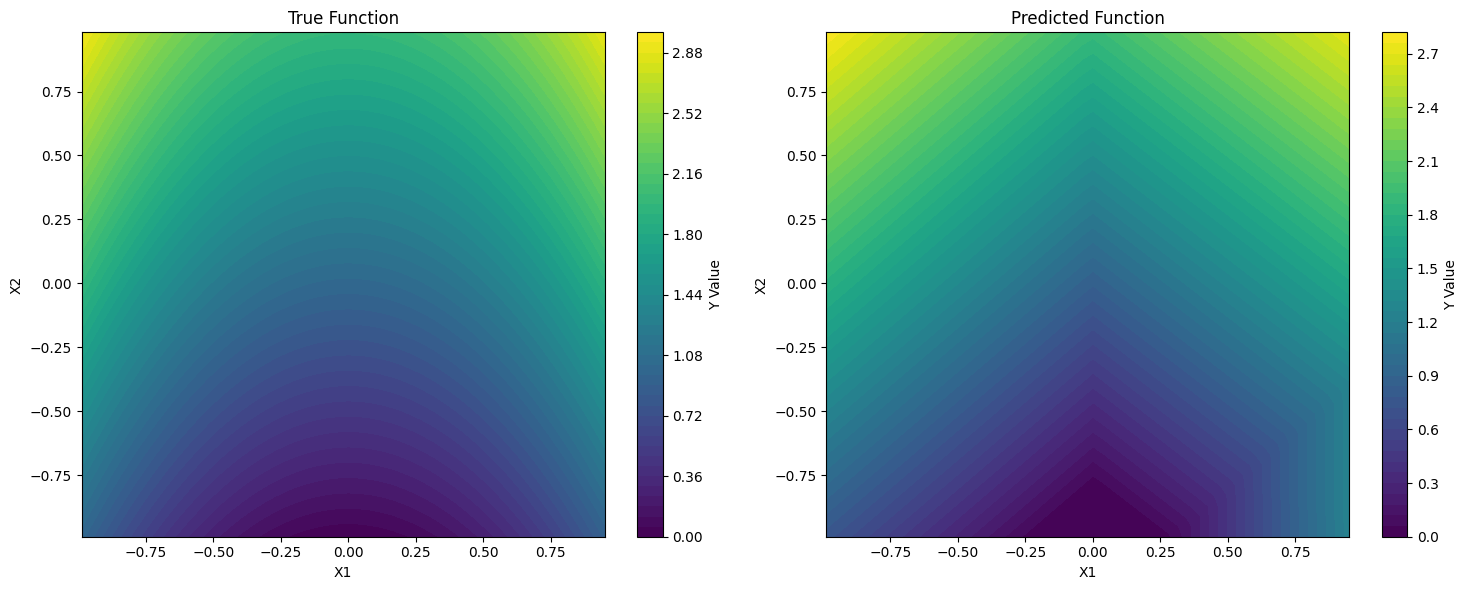

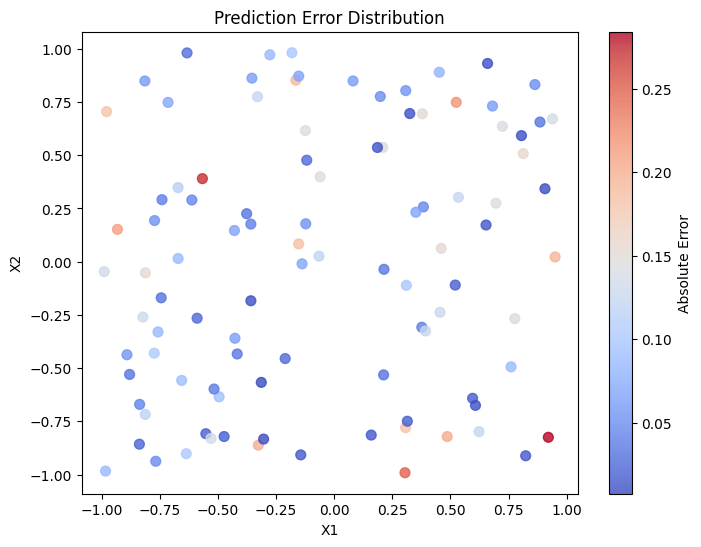


Final weights: [np.float64(-0.8088245701577425), np.float64(1.3816664365559337), np.float64(0.8939415950523416), np.float64(0.006795737820815218), np.float64(1.169292064225921), np.float64(1.304188256048031)]
Final biases: [np.float64(1.127946999216615), np.float64(0.0010351853984202786), np.float64(-0.4707949906751999)]
Final loss: 0.012611727516599048


In [12]:
nn = experiment_default()

EXPERIMENT: Different Learning Rates
--------------------------------------------------
Training with learning rate: 0.005
Epoch 1/1000, Loss: 0.3735
Epoch 100/1000, Loss: 0.0191
Epoch 200/1000, Loss: 0.0155
Epoch 300/1000, Loss: 0.0152
Epoch 400/1000, Loss: 0.0152
Epoch 500/1000, Loss: 0.0152
Epoch 600/1000, Loss: 0.0152
Epoch 700/1000, Loss: 0.0141
Epoch 800/1000, Loss: 0.0139
Epoch 900/1000, Loss: 0.0139
Epoch 1000/1000, Loss: 0.0139
Final loss: 0.0139
Training with learning rate: 0.01
Epoch 1/1000, Loss: 0.3171
Epoch 100/1000, Loss: 0.0162
Epoch 200/1000, Loss: 0.0160
Epoch 300/1000, Loss: 0.0148
Epoch 400/1000, Loss: 0.0145
Epoch 500/1000, Loss: 0.0145
Epoch 600/1000, Loss: 0.0145
Epoch 700/1000, Loss: 0.0145
Epoch 800/1000, Loss: 0.0145
Epoch 900/1000, Loss: 0.0145
Epoch 1000/1000, Loss: 0.0145
Final loss: 0.0145
Training with learning rate: 0.05
Epoch 1/1000, Loss: 0.1871
Epoch 100/1000, Loss: 0.0218
Epoch 200/1000, Loss: 0.0218
Epoch 300/1000, Loss: 0.0218
Epoch 400/1000, Loss:

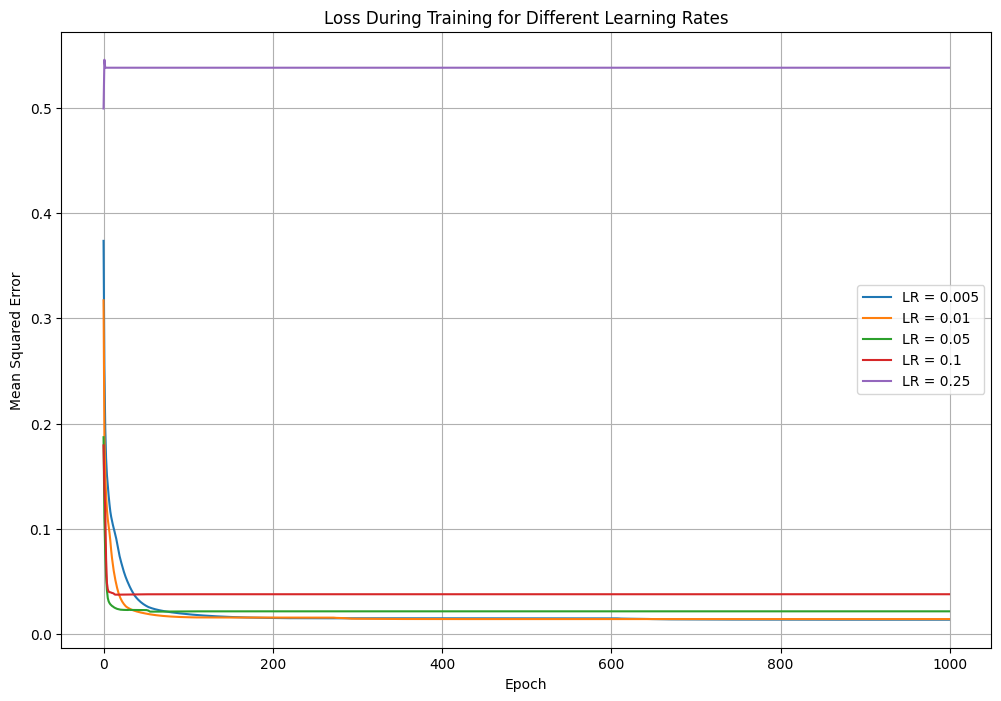

In [13]:
nn = experiment_learning_rate()

EXPERIMENT: Different Data Distributions
--------------------------------------------------
Uniform Distribution:


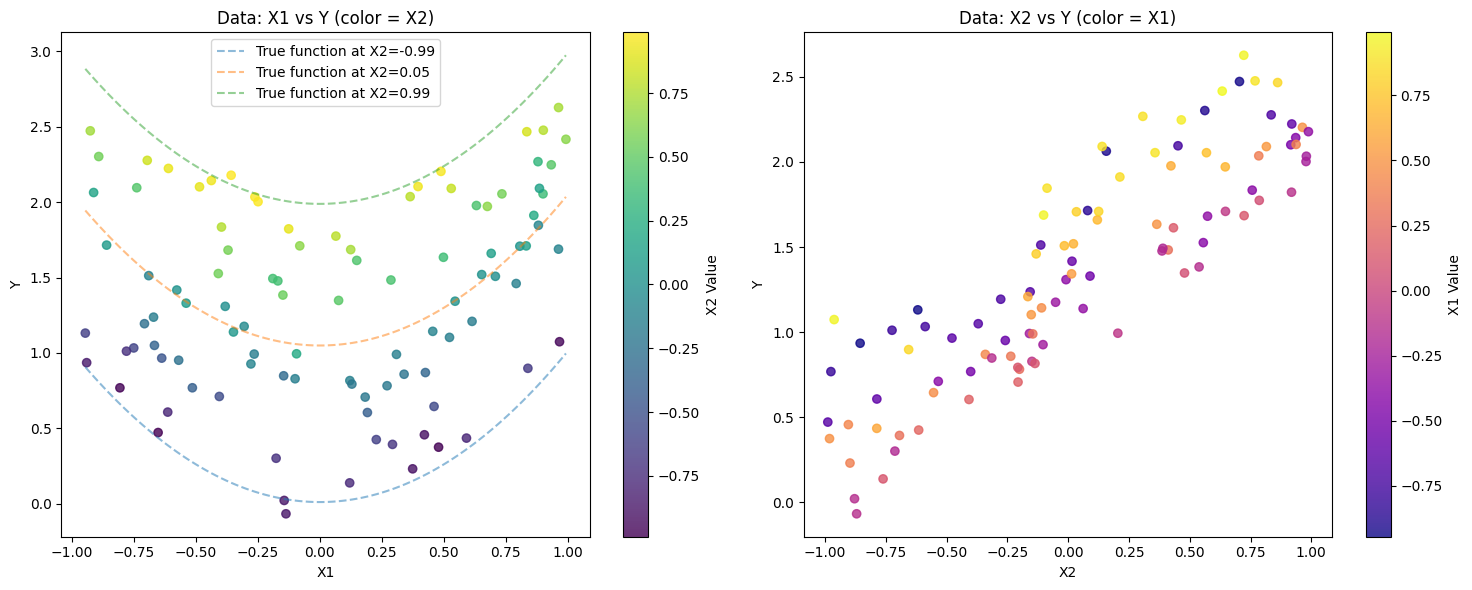

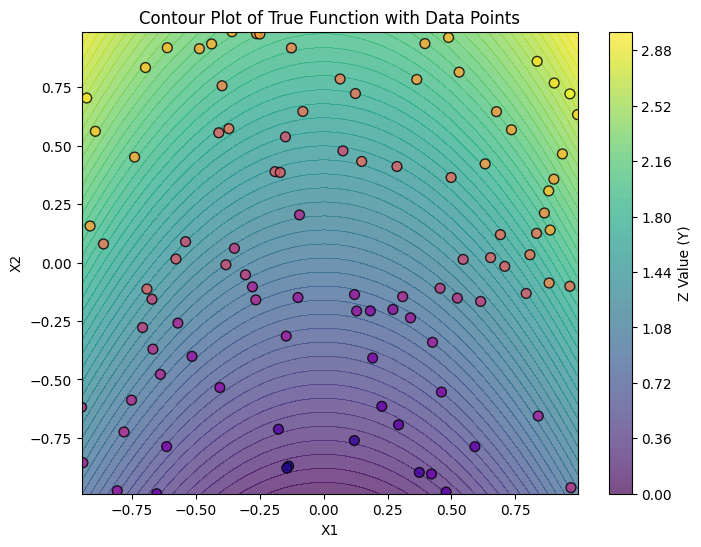

Normal Distribution:


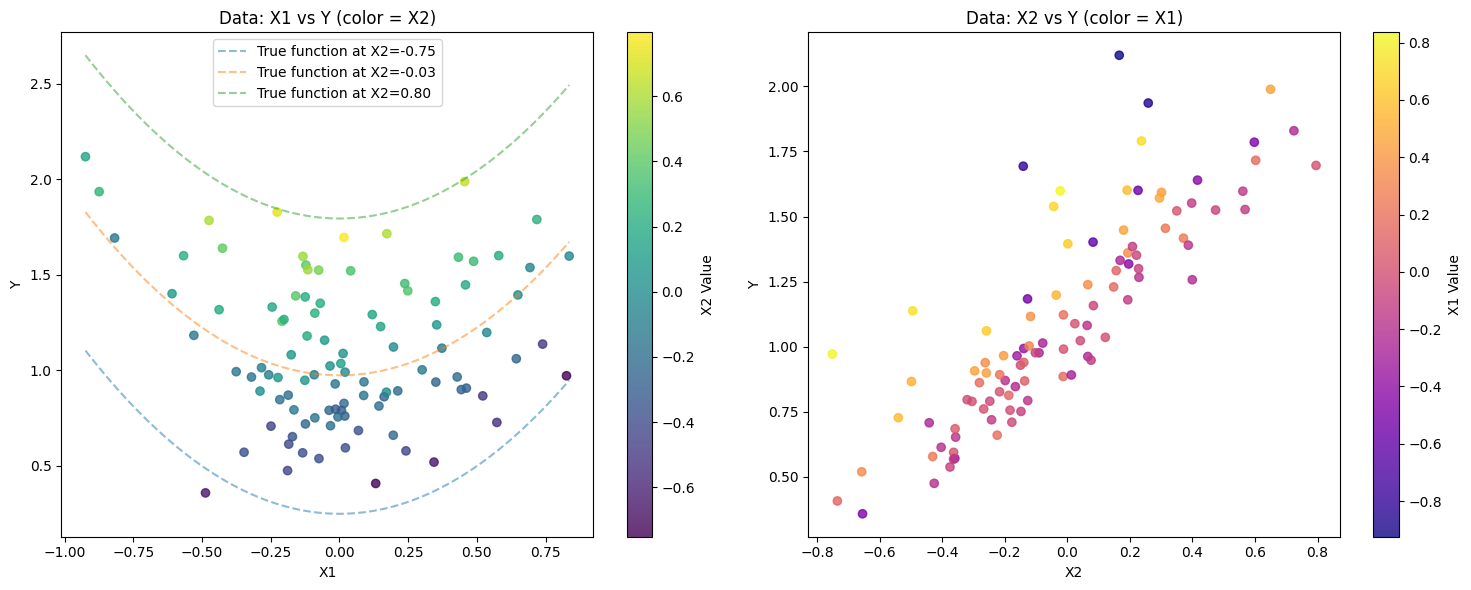

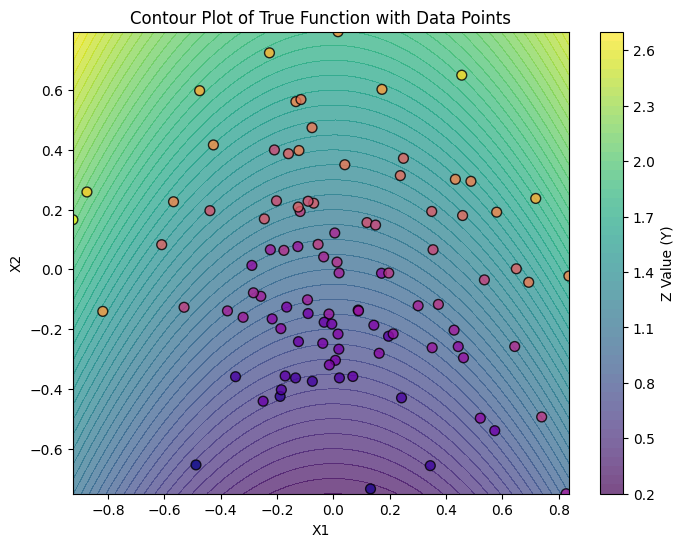

Training on uniform data:
Epoch 1/1000, Loss: 0.2539
Epoch 100/1000, Loss: 0.0135
Epoch 200/1000, Loss: 0.0106
Epoch 300/1000, Loss: 0.0102
Epoch 400/1000, Loss: 0.0101
Epoch 500/1000, Loss: 0.0101
Epoch 600/1000, Loss: 0.0101
Epoch 700/1000, Loss: 0.0101
Epoch 800/1000, Loss: 0.0101
Epoch 900/1000, Loss: 0.0101
Epoch 1000/1000, Loss: 0.0101

Training on normal data:
Epoch 1/1000, Loss: 0.1488
Epoch 100/1000, Loss: 0.0127
Epoch 200/1000, Loss: 0.0106
Epoch 300/1000, Loss: 0.0100
Epoch 400/1000, Loss: 0.0099
Epoch 500/1000, Loss: 0.0099
Epoch 600/1000, Loss: 0.0099
Epoch 700/1000, Loss: 0.0099
Epoch 800/1000, Loss: 0.0099
Epoch 900/1000, Loss: 0.0099
Epoch 1000/1000, Loss: 0.0099


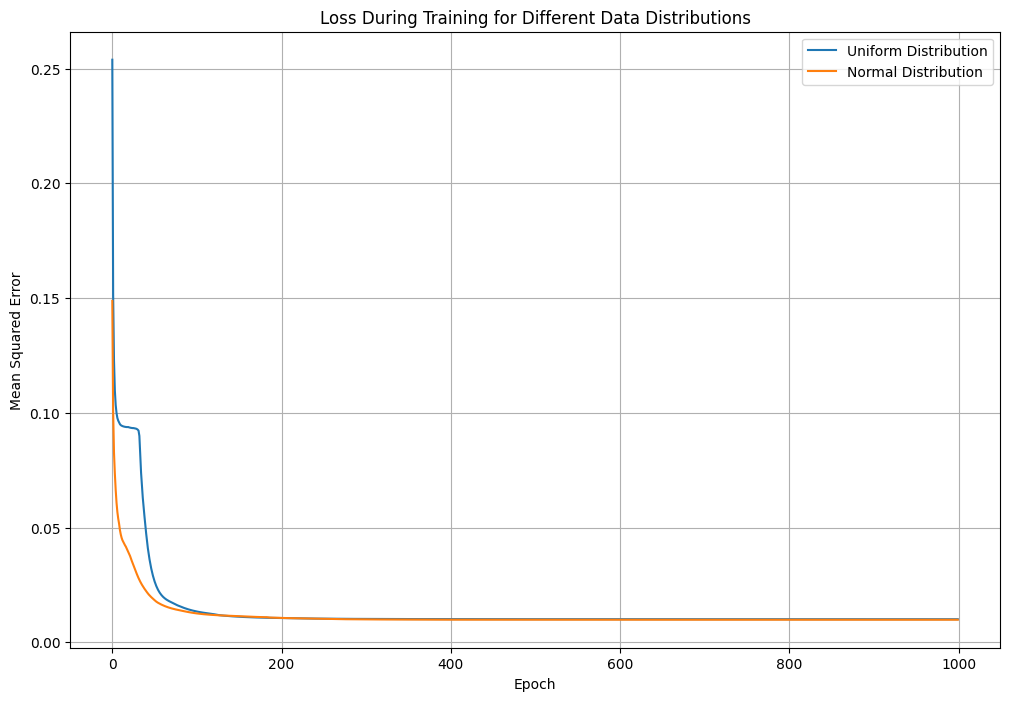

Predictions for uniform data:


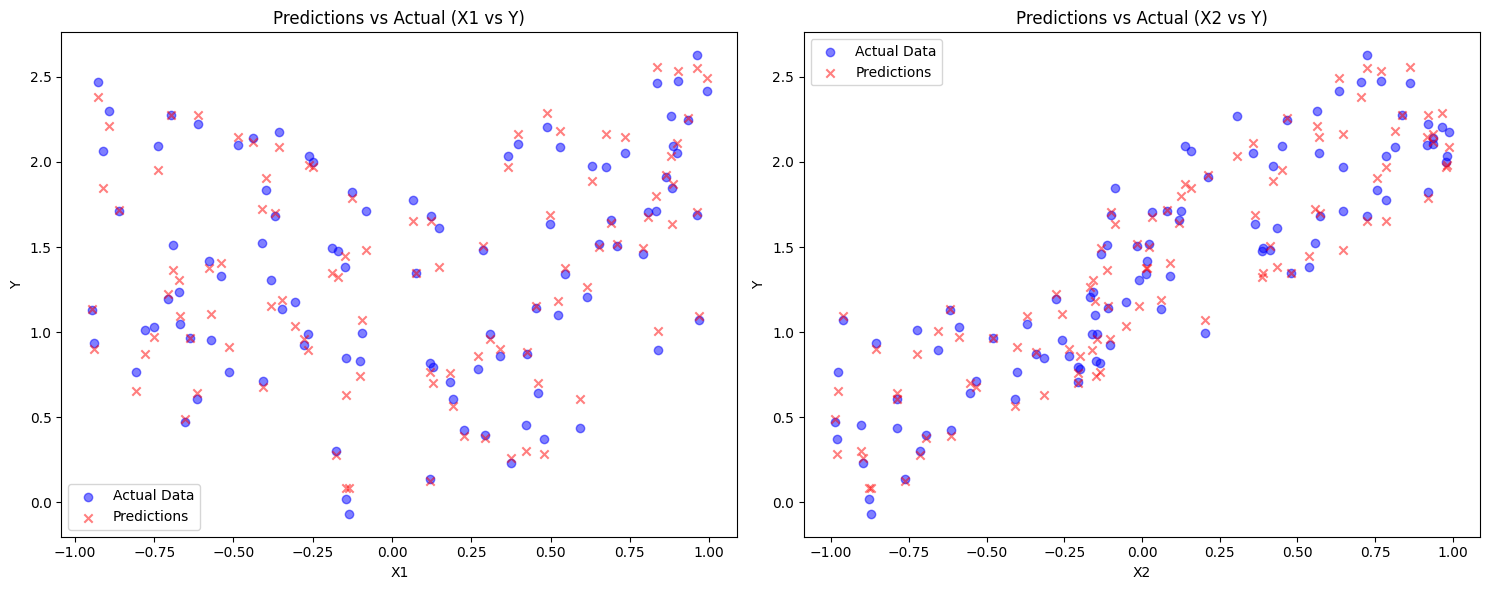

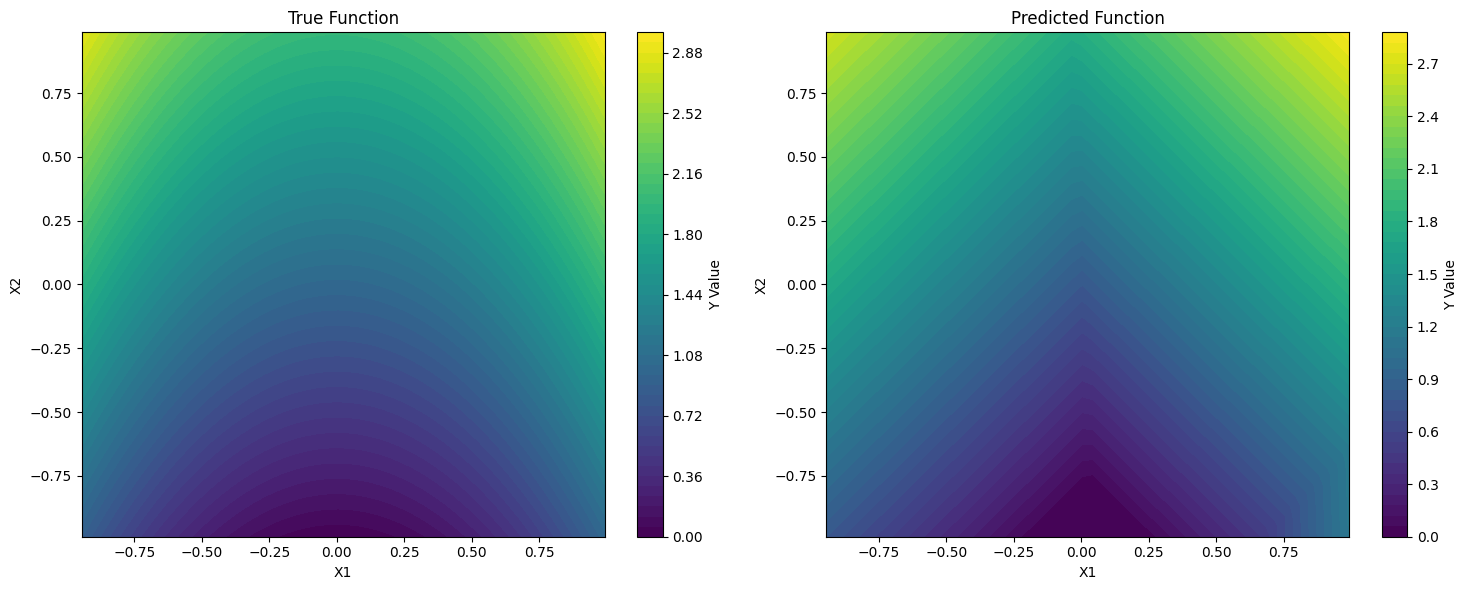

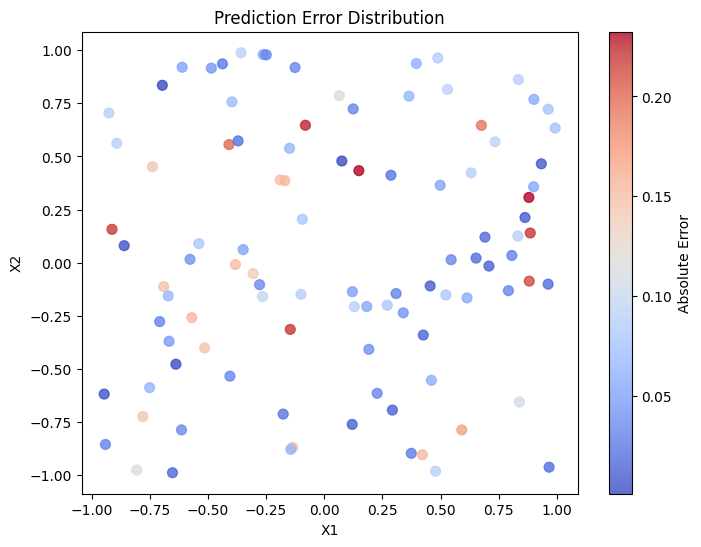

Predictions for normal data:


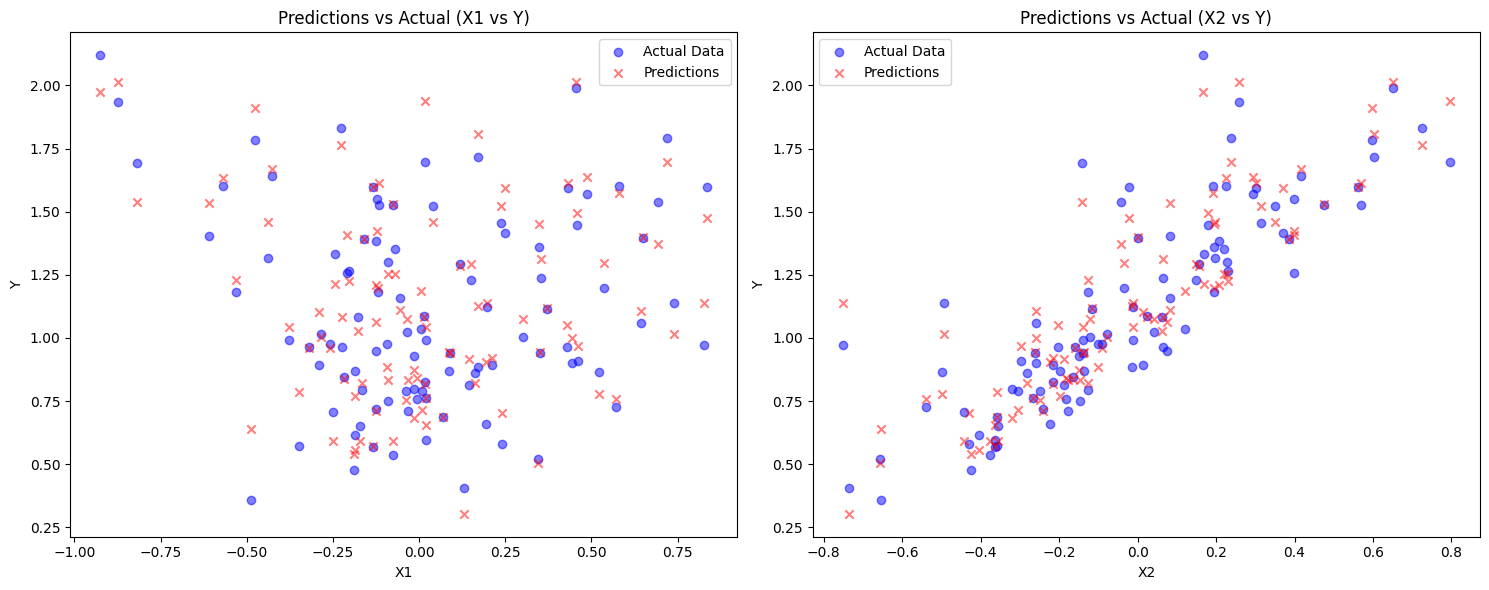

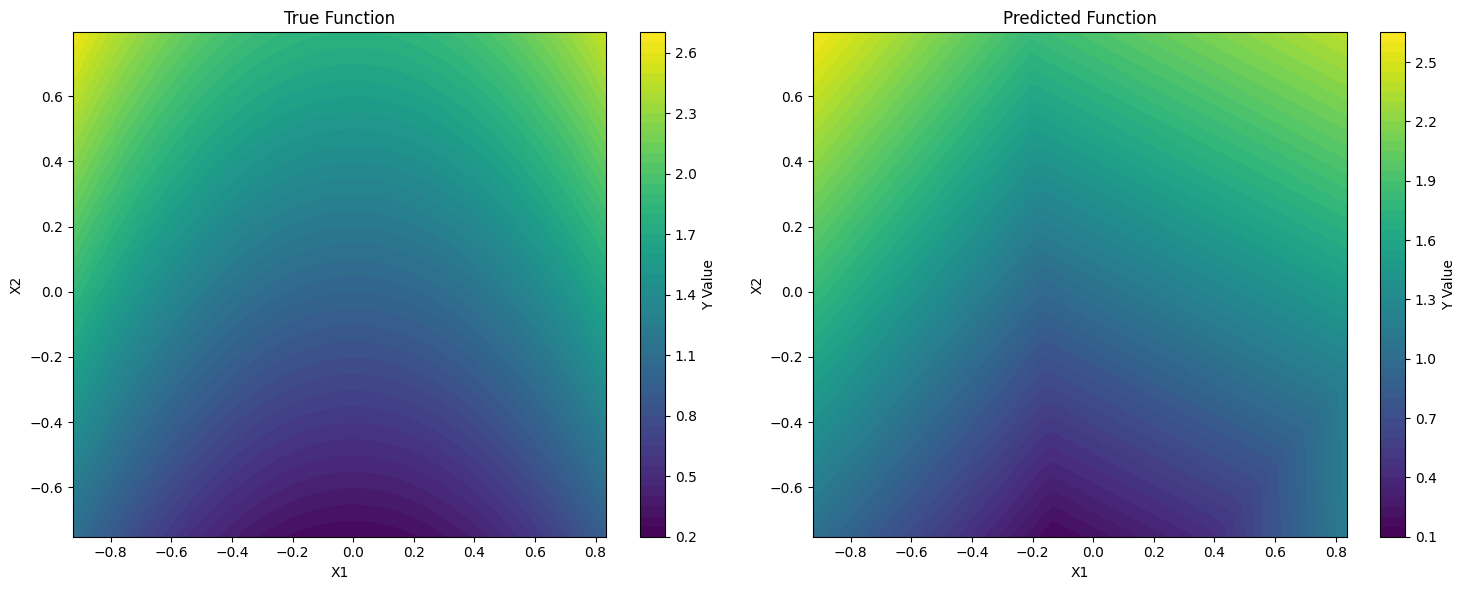

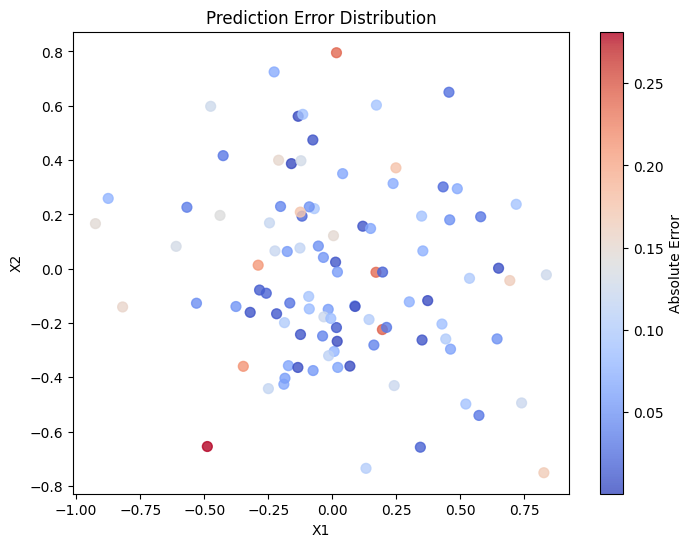

In [14]:
nn = experiment_data_distribution()

EXPERIMENT: Different Dataset Sizes
--------------------------------------------------
Training with dataset size: 30
Epoch 1/1000, Loss: 0.5685
Epoch 100/1000, Loss: 0.0576
Epoch 200/1000, Loss: 0.0184
Epoch 300/1000, Loss: 0.0154
Epoch 400/1000, Loss: 0.0145
Epoch 500/1000, Loss: 0.0144
Epoch 600/1000, Loss: 0.0143
Epoch 700/1000, Loss: 0.0143
Epoch 800/1000, Loss: 0.0143
Epoch 900/1000, Loss: 0.0143
Epoch 1000/1000, Loss: 0.0143
Final loss: 0.0143
Training with dataset size: 100
Epoch 1/1000, Loss: 0.4116
Epoch 100/1000, Loss: 0.0168
Epoch 200/1000, Loss: 0.0158
Epoch 300/1000, Loss: 0.0158
Epoch 400/1000, Loss: 0.0157
Epoch 500/1000, Loss: 0.0157
Epoch 600/1000, Loss: 0.0157
Epoch 700/1000, Loss: 0.0157
Epoch 800/1000, Loss: 0.0157
Epoch 900/1000, Loss: 0.0157
Epoch 1000/1000, Loss: 0.0157
Final loss: 0.0157
Training with dataset size: 300
Epoch 1/1000, Loss: 0.2023
Epoch 100/1000, Loss: 0.0172
Epoch 200/1000, Loss: 0.0172
Epoch 300/1000, Loss: 0.0171
Epoch 400/1000, Loss: 0.0171
E

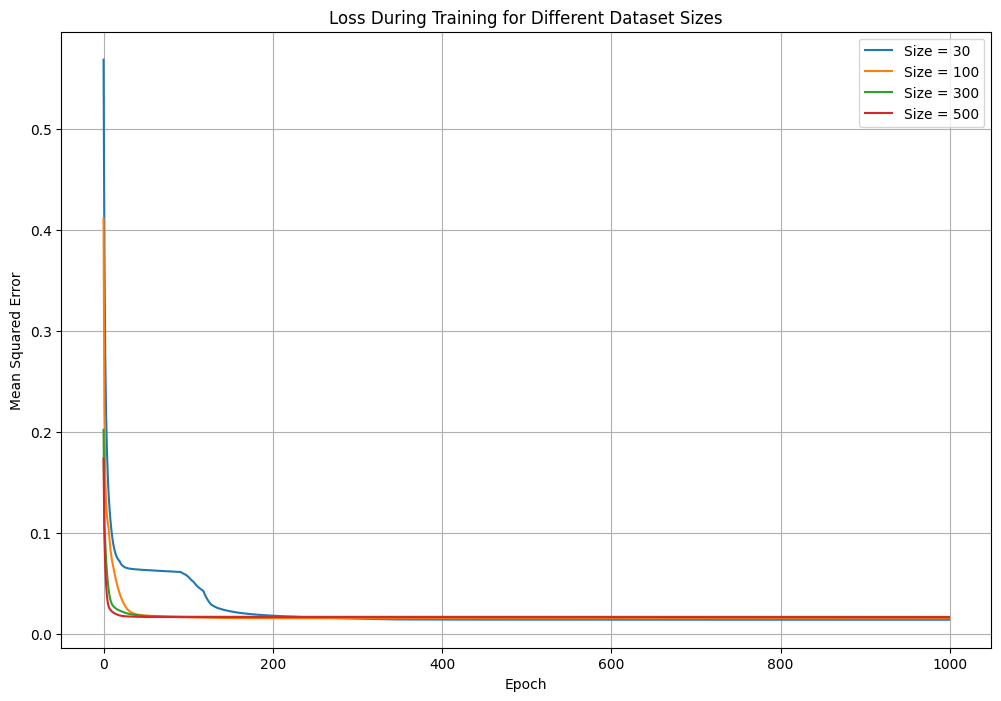

In [15]:
nn = experiment_dataset_size()

EXPERIMENT: Random Weight and Bias Initialization
--------------------------------------------------
Trial 1
Initial weights: [ 0.64434976 -0.53128526  0.91802425  0.18893534 -0.45817896  0.25667936]
Initial biases: [ 0.27305221  0.63411048 -0.26180159]
Epoch 1/1000, Loss: 1.4273
Epoch 100/1000, Loss: 0.0190
Epoch 200/1000, Loss: 0.0180
Epoch 300/1000, Loss: 0.0179
Epoch 400/1000, Loss: 0.0179
Epoch 500/1000, Loss: 0.0179
Epoch 600/1000, Loss: 0.0179
Epoch 700/1000, Loss: 0.0179
Epoch 800/1000, Loss: 0.0179
Epoch 900/1000, Loss: 0.0179
Epoch 1000/1000, Loss: 0.0179
Final loss: 0.0179

Trial 2
Initial weights: [-0.45944006  0.07007701 -0.25896674  0.17614675  0.69769933 -0.81371772]
Initial biases: [ 0.751235   -0.25762112 -0.38475121]
Epoch 1/1000, Loss: 0.7297
Epoch 100/1000, Loss: 0.1073
Epoch 200/1000, Loss: 0.1073
Epoch 300/1000, Loss: 0.1072
Epoch 400/1000, Loss: 0.1072
Epoch 500/1000, Loss: 0.1072
Epoch 600/1000, Loss: 0.1072
Epoch 700/1000, Loss: 0.1072
Epoch 800/1000, Loss: 0.1

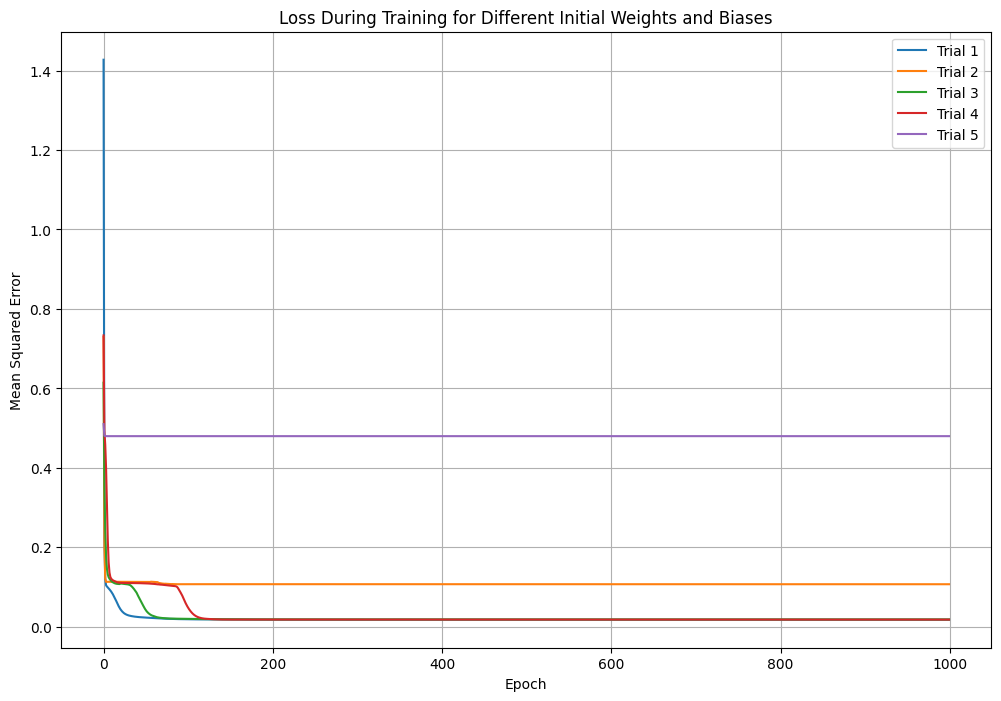

In [16]:
nn = experiment_random_initialization()